In [1]:
import xarray as xr
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
import warnings

In [2]:
path='/mnt/1A42C1DD42C1BE2F/MyProjects/ML_HEATWAVE/Precipitation/*.nc'
precp_data=xr.open_mfdataset(path)


In [3]:
precp_data.prate

<xarray.DataArray 'prate' (time: 15340, lat: 94, lon: 192)>
dask.array<concatenate, shape=(15340, 94, 192), dtype=float32, chunksize=(366, 94, 192), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 88.54 86.65 84.75 82.85 ... -84.75 -86.65 -88.54
  * lon      (lon) float32 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * time     (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2022-12-31
Attributes:
    long_name:     mean Daily Precipitation Rate at surface
    units:         Kg/m^2/s
    precision:     7
    GRIB_id:       59
    GRIB_name:     PRATE
    var_desc:      Precipitation Rate
    dataset:       NCEP Reanalysis Daily Averages
    level_desc:    Surface
    statistic:     Mean
    parent_stat:   Individual Obs
    actual_range:  [9.9884346e-08 1.8119999e-03]
    valid_range:   [0.    0.005]

##### We need to fix Grid sizes here.

In [4]:
new_lat = np.arange(90, -91, -02.5).astype(np.float32)
new_lon = np.arange(0, 360, 02.5).astype(np.float32)

# Resample to the new grid size
resized_precp = precp_data.interp(lat=new_lat, lon=new_lon)

In [5]:
lat_range = slice(29,18.0)  # take lat values in backwards directions.
lon_range = slice(85, 97)  # 88.0 degrees east to 92.7 degrees east

# Use the sel method to select data within the specified Bangladesh region
bangladesh_resized_precp = resized_precp.sel(lat=lat_range,lon=lon_range)
bangladesh_resized_precp

<xarray.Dataset>
Dimensions:    (time: 15340, lat: 4, lon: 5, nbnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2022-12-31
  * lat        (lat) float32 27.5 25.0 22.5 20.0
  * lon        (lon) float32 85.0 87.5 90.0 92.5 95.0
Dimensions without coordinates: nbnds
Data variables:
    prate      (time, lat, lon) float32 dask.array<chunksize=(365, 4, 5), meta=np.ndarray>
    time_bnds  (time, nbnds) float64 dask.array<chunksize=(365, 2), meta=np.ndarray>
Attributes:
    Conventions:    COARDS
    title:          mean daily NMC reanalysis (1981)
    description:    Data is from NMC initialized reanalysis\n(4x/day).  It co...
    platform:       Model
    history:        created 95/03/13 by Hoop (netCDF2.3)\nConverted to chunke...
    dataset_title:  NCEP-NCAR Reanalysis 1
    References:     http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis...

In [6]:
import pandas as pd
import xarray as xr
from tqdm.auto import tqdm# Import tqdm
warnings.filterwarnings('ignore')

# # Open your netCDF dataset
# ds = xr.open_dataset('your_dataset.nc')

# Define the chunk size
chunk_size = 500  # Adjust this based on your available memory

# Initialize an empty DataFrame to store the results
prate_df = pd.DataFrame(columns=['time', 'lat', 'lon', 'prate'])

# Calculate the number of chunks
num_chunks = len(bangladesh_resized_precp.time)

# Create a tqdm progress bar
for start in tqdm(range(0, num_chunks, chunk_size),desc='Main Loop'):
    end = start + chunk_size
    chunk = bangladesh_resized_precp.isel(time=slice(start, end))

    # Extract the data
    time = chunk.time.values
    lat = chunk.lat.values
    lon = chunk.lon.values
    prate = chunk.prate.values

    # Create a DataFrame for this chunk and append it to the main DataFrame
    chunk_df = pd.DataFrame({
        'time': time.repeat(len(lat) * len(lon)),
        'lat': np.tile(lat, len(time) * len(lon)),
        'lon': np.tile(lon, len(time) * len(lat)),
        'prate': prate.ravel()
    })

    prate_df = prate_df.append(chunk_df, ignore_index=True)

# t2m_df now contains the concatenated data
prate_df

Main Loop:   0%|          | 0/31 [00:00<?, ?it/s]

,time,lat,lon,prate
0,1981-01-01,27.5,85.0,9.988435e-08
1,1981-01-01,25.0,87.5,9.988435e-08
2,1981-01-01,22.5,90.0,1.286696e-06
3,1981-01-01,20.0,92.5,4.786846e-06
4,1981-01-01,27.5,95.0,1.994594e-05
...,...,...,...,...
306795,2022-12-31,20.0,85.0,0.000000e+00
306796,2022-12-31,27.5,87.5,0.000000e+00
306797,2022-12-31,25.0,90.0,0.000000e+00
306798,2022-12-31,22.5,92.5,0.000000e+00


In [7]:
import pandas as pd

# Create a sample DataFrame
# data = {'A': [1, 2, 3, 4],
#         'B': [5, 6, 7, 8]}

# df = pd.DataFrame(data)
precp_df=prate_df
# Multiply a column by a constant
precp_df['daily_precp'] = precp_df['prate'] * 86400

# Multiply one column by another
# df['C'] = df['A'] * df['B']
precp_df
# print(df)

,time,lat,lon,prate,daily_precp
0,1981-01-01,27.5,85.0,9.988435e-08,0.008630
1,1981-01-01,25.0,87.5,9.988435e-08,0.008630
2,1981-01-01,22.5,90.0,1.286696e-06,0.111171
3,1981-01-01,20.0,92.5,4.786846e-06,0.413584
4,1981-01-01,27.5,95.0,1.994594e-05,1.723329
...,...,...,...,...,...
306795,2022-12-31,20.0,85.0,0.000000e+00,0.000000
306796,2022-12-31,27.5,87.5,0.000000e+00,0.000000
306797,2022-12-31,25.0,90.0,0.000000e+00,0.000000
306798,2022-12-31,22.5,92.5,0.000000e+00,0.000000


In [8]:
precp_df['time'][:][5:7]

5   1981-01-01
6   1981-01-01
Name: time, dtype: datetime64[ns]

In [9]:
# monthly_data = precp_df[precp_df['time'].dt.month == '1.0']
# monthly_data

# Monthwise rainfall

In [11]:
import pandas as pd
import calendar

# Assuming precp_df is your DataFrame with the precipitation data
# Convert the 'time' column to datetime format
precp_df['time'] = precp_df['time'].dt.strftime('%Y-%m-%d %H:%M:%S')

# Create an empty DataFrame to store the monthly totals
monthly_totals = pd.DataFrame(columns=['Month', 'Total Precipitation'])

# Get unique months
months=precp_df['time'].str[5:7].unique()

for month in months:
    # Filter the DataFrame for the current month
    monthly_data = precp_df[precp_df['time'].str[5:7]==month]
    
    # Calculate the total precipitation for the month
    total_precipitation = monthly_data['daily_precp'].sum()
    month_name=calendar.month_name[int(month)]

    
    # Append the result to the monthly_totals DataFrame
    monthly_totals = monthly_totals.append({'Month': month_name, 'Total Precipitation': total_precipitation}, ignore_index=True)

# Display the monthly totals
monthly_totals

,Month,Total Precipitation
0,January,13703.333489
1,February,14912.373340
2,March,19980.538147
3,April,53785.737231
4,May,132667.024969
5,June,254793.393109
6,July,327875.947509
7,August,288551.008851
8,September,214760.570252
9,October,119068.579401


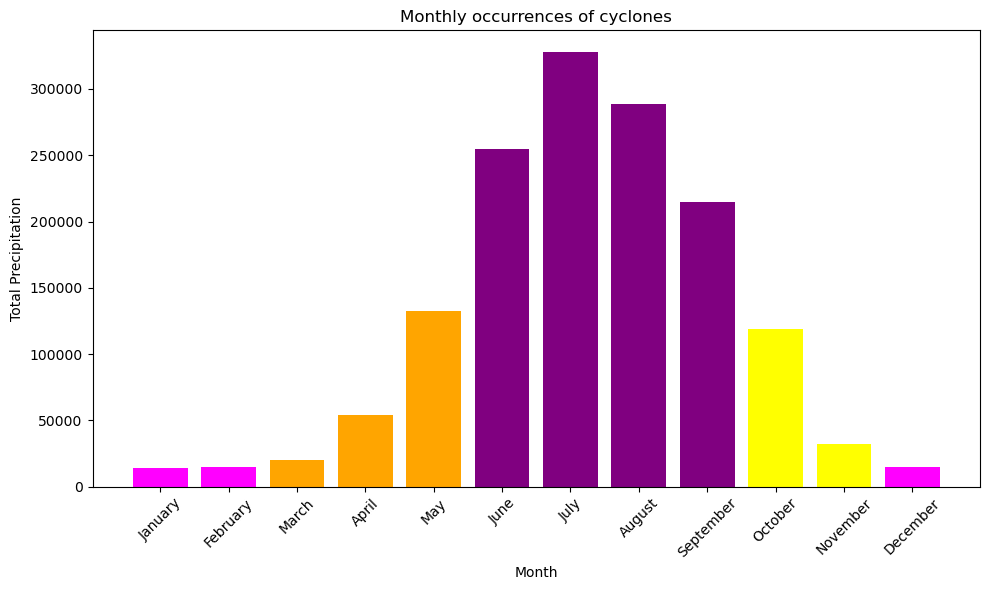

-----------------------------------------
Premoonson---orange,Moonsoon-----purple,Postmoonsoon-yellow


In [12]:
# Create a bar plot
plt.figure(figsize=(10, 6))

colors = ['magenta', 'magenta', 'orange', 'orange', 'orange', 'purple', 'purple', 'purple', 'purple', 'yellow', 'yellow', 'magenta']
plt.bar(monthly_totals['Month'], monthly_totals['Total Precipitation'],color=colors)
plt.xlabel('Month')
plt.ylabel('Total Precipitation')
plt.title('Monthly occurrences of cyclones')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()
print('-----------------------------------------')
print('Premoonson---orange,Moonsoon-----purple,Postmoonsoon-yellow')

### Yearly Rainfall

In [14]:
yearly_totals = pd.DataFrame(columns=['year', 'Total Precipitation'])

# Get unique years
years=precp_df['time'].str[:4].unique()

for year in years:
    # Filter the DataFrame for the current year
    yearly_data = precp_df[precp_df['time'].str[:4]==year]
    
    # Calculate the total precipitation for the year
    total_precipitation = yearly_data['daily_precp'].sum()

    # Append the result to the yearly_totals DataFrame
    yearly_totals = yearly_totals.append({'year': year, 'Total Precipitation': total_precipitation}, ignore_index=True)

# Display the yearly totals
yearly_totals

,year,Total Precipitation
0,1981,34056.894392
1,1982,32646.208104
2,1983,36739.911566
3,1984,35446.414279
4,1985,35112.909273
5,1986,36769.824880
6,1987,35354.142030
7,1988,38403.272492
8,1989,33426.464784
9,1990,37449.507081


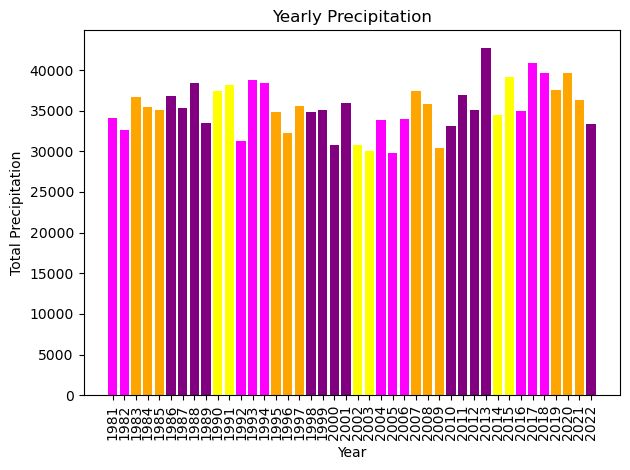

In [15]:
plt.bar(yearly_totals['year'],yearly_totals['Total Precipitation'],color=colors)
plt.xlabel('Year')
plt.ylabel('Total Precipitation')
plt.title('Yearly Precipitation')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# precp_df['time']=pd.to_datetime(precp_df['time'])
# precp_df.set_index('time', inplace=True)
# monthly_precipitation=precp_df.groupby(pd.Grouper(freq="M")).sum()

In [ ]:
# precp_df['time'].str[:4]

In [ ]:
# months=precp_df['time'].str[:4].unique()
# months

In [ ]:
# precp_df['time'] = precp_df['time'].dt.strftime('%Y-%m-%d %H:%M:%S')

In [ ]:
# monthly_data = precp_df[precp_df['time'].str[5:7]=='01']
# monthly_data

In [ ]:
# monthly_data.daily_precp.sum()

In [ ]:
# months=precp_df['time'].str[5:7].unique()

In [ ]:
# months